# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [32]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from addict import Dict as Adict
import mdshare

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import vampnet_loss

from celerity.models import VAMPnetEstimator, VAMPNetModel


In [33]:
dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory='data'
)

### Load data

In [34]:
with np.load(Path('data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz').open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

### Configuration

In [9]:
lag_time = 1
validation_split = 0.3
batch_size = 1000

# vampnet estimator config
nn_config = Adict(
        lag_time = lag_time, 
        network_dimensions = [30, 100, 100,100, 6], 
        lr = 5e-4, 
        n_epochs = 5, 
        optimizer=torch.optim.Adam, 
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cuda"
    ) 

In [47]:
dataset = to_dataset(data=data, lagtime=lag_time)
n_val = int(len(dataset)*validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 
loader_traj = DataLoader(data[0], batch_size=len(data[0]), shuffle=False)
loader_trajs = [DataLoader(x, batch_size=len(x), shuffle=False) for x in data]

### Fit and transform

In [43]:
est = VAMPnetEstimator(nn_config)
est.fit(loader_train, loader_val)
mod = VAMPNetModel({'estimator': est, 'device': 'cuda'})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

### State assigments and timescales

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

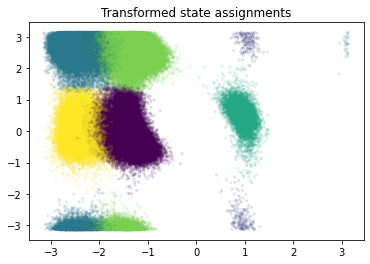

In [46]:

state_probabilities = mod.transform(loader_traj)

assignments = state_probabilities[0].argmax(1)
plt.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
plt.title('Transformed state assignments');

In [52]:
state_probabilities = [mod.transform(loader)[0] for loader in loader_trajs]


Transform:   0%|          | 0/1 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
vamp_estimator = VAMP(lagtime=lag_time)
vamp_estimator.fit_from_timeseries(state_probabilities)
vamp_model = vamp_estimator.fetch_model()
with np.printoptions(precision=1, suppress=True):
    print(vamp_model.timescales(6))

[1169.5   57.6   25.5    2.3    1.5]
